# Exploratory Data Analysis (EDA)

**🔄 EDA Workflow for Classification**

- 🔍 Data Snapshot Use df.head(), .info(), .describe() to check basic structure, types, and nulls. ➤ GeeksforGeeks – EDA Steps
- 🎯 Target Check Run y.value_counts() to verify class labels and spot imbalance.
- 🧩 Variable Typing Confirm feature types: numerical, categorical, text, date. Use the type-detection script from Milestone 3 Lesson 1.
- 📊 Univariate Exploration
  - Numeric: Histograms or KDE plots
  - Categorical: Countplots ➤ Seaborn Distribution Plots
- 🧪 Bivariate Exploration
  - Box/violin plots for numeric features across classes
  - Stacked bar plots for categorical vs. target
- 🔥 Correlation Heatmap Use Spearman (for ranking) or Pearson (for linear) correlations to detect redundant numeric features.
- 🔀 Multivariate Preview Use pair-plots or dimensionality reduction (e.g. t-SNE, PCA) to explore high-dimensional patterns.
- ⚖️ Class Balance Visualization Plot class proportions side-by-side to detect severe imbalance.
- ❗ Missing & Outlier Maps
  - Heatmaps for missing values
  - Scatterplots with Isolation Forest to highlight outliers

In [1]:
import pandas as pd
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.feature_selection import mutual_info_classif

df = pd.read_csv("../data/interim/cleaned_yield_tables.csv")

target_variable = "tree_type"
features = [
    "yield_class",
    "age",
    "average_height",
    "dbh",
    "taper",
    "trees_per_ha",
    "basal_area",
]

df.head()

,tree_type,yield_class,age,average_height,dbh,taper,trees_per_ha,basal_area
0,coniferous,15.0,20.0,5.3,11.5,0.396,2585.0,26.8
1,coniferous,15.0,30.0,10.6,16.7,0.458,1708.0,37.5
2,coniferous,15.0,40.0,15.7,21.6,0.460,1266.0,46.3
3,coniferous,15.0,50.0,20.5,26.1,0.456,1003.0,53.5
4,coniferous,15.0,60.0,24.6,30.2,0.451,830.0,59.4


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4025 entries, 0 to 4024
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tree_type       4025 non-null   object 
 1   yield_class     4025 non-null   float64
 2   age             4025 non-null   float64
 3   average_height  4025 non-null   float64
 4   dbh             4025 non-null   float64
 5   taper           4025 non-null   float64
 6   trees_per_ha    4025 non-null   float64
 7   basal_area      4025 non-null   float64
dtypes: float64(7), object(1)
memory usage: 251.7+ KB


In [3]:
df[target_variable].value_counts()

tree_type
coniferous    3242
deciduous      783
Name: count, dtype: int64

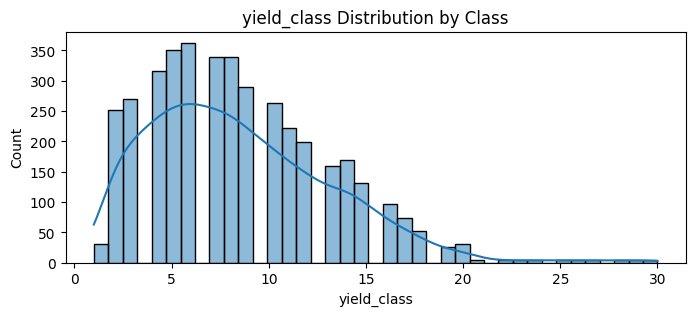

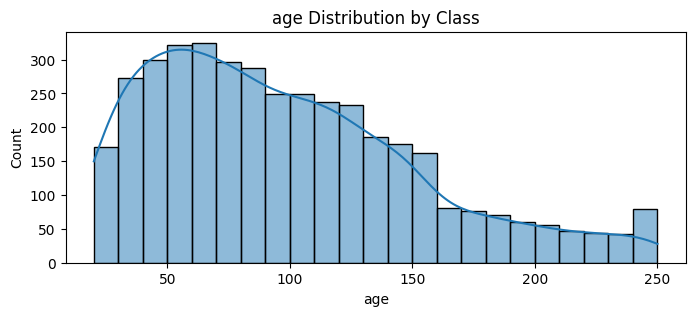

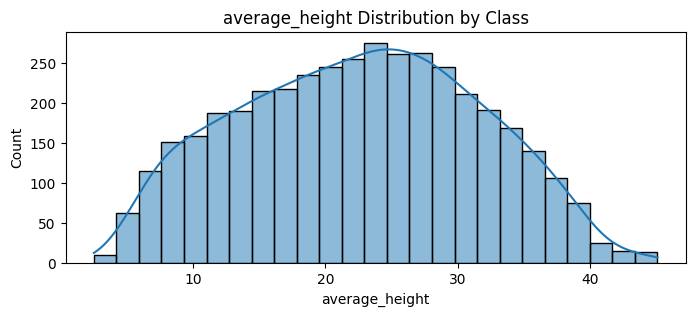

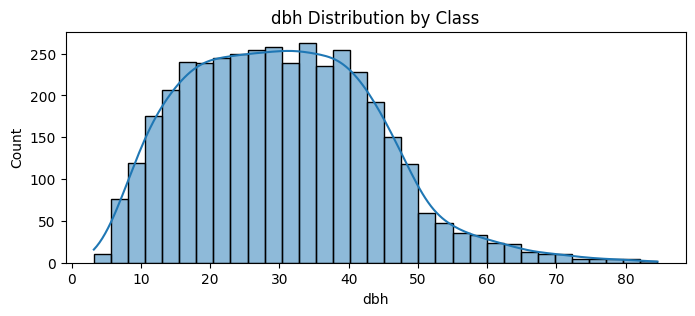

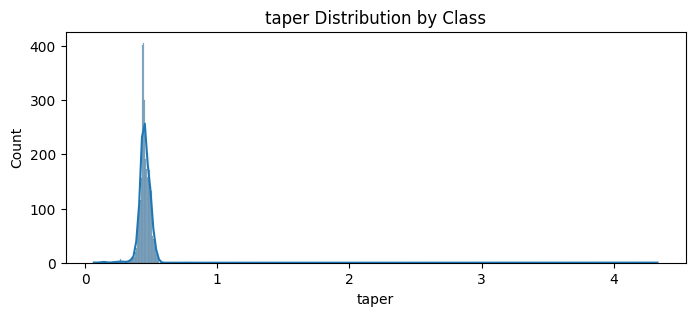

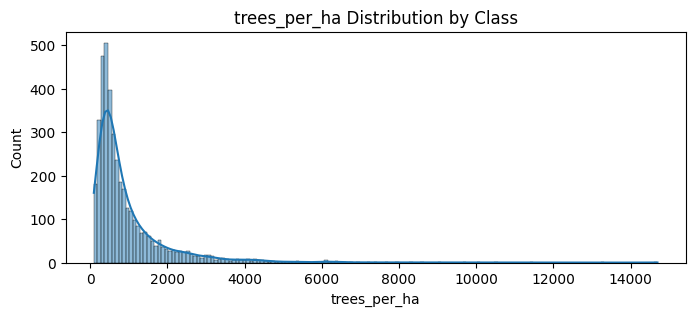

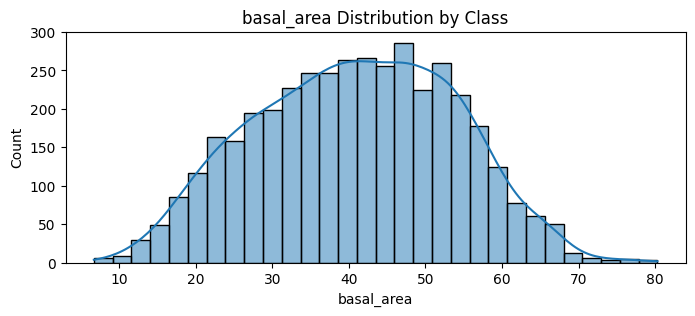

In [4]:
for feature in features:
    plt.figure(figsize=(8, 3))
    sns.histplot(df[feature], kde=True, multiple="stack")
    plt.title(f"{feature} Distribution by Class")
    plt.show()

In [5]:
for feature in features:
    ct = pd.crosstab(df[feature], df[target_variable])
    chi2, p, *_ = chi2_contingency(ct)
    print(
        f"Chi-square of {feature} with {target_variable}: {chi2:.2f}, p-value: {p:.3g}"
    )

Chi-square of yield_class with tree_type: 348.15, p-value: 2.09e-56
Chi-square of age with tree_type: 469.82, p-value: 4.46e-81
Chi-square of average_height with tree_type: 757.50, p-value: 1
Chi-square of dbh with tree_type: 1091.29, p-value: 1
Chi-square of taper with tree_type: 821.36, p-value: 1
Chi-square of trees_per_ha with tree_type: 1764.78, p-value: 0.334
Chi-square of basal_area with tree_type: 3179.35, p-value: 4.07e-43


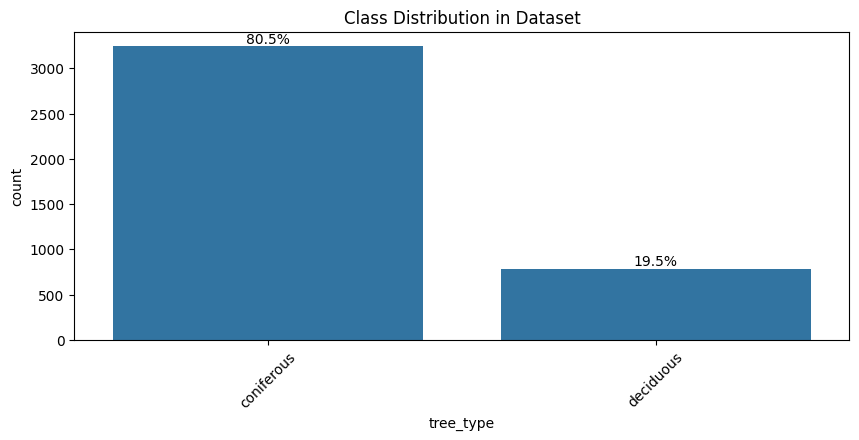

In [6]:
# Basic class distribution
plt.figure(figsize=(10, 4))
sns.countplot(
    data=df, x=target_variable, order=df[target_variable].value_counts().index
)
plt.title("Class Distribution in Dataset")
plt.xticks(rotation=45)

# Add percentage labels
total = len(df)
for p in plt.gca().patches:
    percentage = f"{100*p.get_height()/total:.1f}%"
    plt.gca().annotate(
        percentage,
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="bottom",
    )

In [7]:
mi_scores = mutual_info_classif(df[features], df[target_variable])

print(mi_scores)

[0.03126678 0.06911287 0.00291739 0.         0.06272893 0.030822
 0.155899  ]


## The Feature Engineering Pipeline

A professional workflow typically follows these steps:

- **Handle missing values** with domain-informed strategies.
- **Transform distributions** to align with algorithm assumptions.
- **Encode categorical variables** appropriately for their type and size.
- **Create interaction terms** between predictive feature pairs.
- **Generate domain-specific features** using business knowledge.
- **Scale numerical features** consistently across splits.
- **Select features** using statistical and model-based methods.

In [8]:
# Simple feature engineering plan
def plan_feature_engineering(df, target_col):
    """Simple planning function for feature engineering"""
    plan = {
        "numerical_features": [],
        "categorical_features": [],
        "datetime_features": [],
        "missing_features": [],
    }

    for col in df.columns:
        if col == target_col:
            continue

        if df[col].dtype in ["int64", "float64"]:
            plan["numerical_features"].append(col)
        elif df[col].dtype == "object":
            plan["categorical_features"].append(col)
        elif "datetime" in str(df[col].dtype):
            plan["datetime_features"].append(col)

        # Check for missing values
        if df[col].isnull().sum() > 0:
            plan["missing_features"].append(col)

    return plan


# Usage
plan = plan_feature_engineering(df, target_variable)
print("Feature engineering plan:")
for category, features in plan.items():
    print(f"{category}: {features}")

Feature engineering plan:
numerical_features: ['yield_class', 'age', 'average_height', 'dbh', 'taper', 'trees_per_ha', 'basal_area']
categorical_features: []
datetime_features: []
missing_features: []
